In [1]:
# Install packages #
# !pip install numpy
# !pip install matplotlib
# !pip install torch
# !pip install xlrd
# !pip install pandas
# !pip install torchvision

In [2]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets, transforms

In [3]:
# Loading training data
dataset = pd.read_csv("bmi_train.csv")
dataset.replace({'Gender': {'Female': 0, 'Male': 1}}, inplace=True) #Gender -> boolean
dataset = dataset.to_numpy()

# Splitting off 80% of data for training, 20% for validation
train_split = int(0.8 * len(dataset))
X_train = dataset[:train_split, [0,1,2]]
y_train = dataset[:train_split, 3]
X_test = dataset[train_split:, [0,1,2]]
y_test = dataset[train_split:, 3]

# Loading prediction data
prediction_dataset = pd.read_csv("bmi_validation.csv")
prediction_dataset.replace({'Gender': {'Female': 0, 'Male': 1}}, inplace=True) #Gender -> boolean
X_prediction = prediction_dataset.to_numpy()

# Normalize data set
X_train_normalized = (X_train - X_train.min(0)) / (X_train.max(0) - X_train.min(0))
X_test_normalized = (X_test - X_test.min(0)) / (X_test.max(0) - X_test.min(0))
X_prediction_normalized = (X_prediction - X_prediction.min(0)) / (X_prediction.max(0) - X_prediction.min(0))

# Turn data to tensor
X_train_tensor = torch.from_numpy(X_train_normalized)
y_train_tensor = torch.from_numpy(y_train)
X_test_tensor = torch.from_numpy(X_test_normalized)
y_test_tensor = torch.from_numpy(y_test)
X_prediction_tensor = torch.from_numpy(X_prediction_normalized)

In [4]:
# Train and test error rate analysis function
def calculate_error_rate(X, y, w, b):
    num_samples = X.shape[0]
    y_pred = np.dot(X, w) + b
    error = y_pred - y
    squared_error = np.square(error)
    mean_squared_error = np.mean(squared_error)
    error_rate = np.sqrt(mean_squared_error)
    return error_rate

Custom SGD

Learned parameters:
w0 = 0.060808857709234714
w1 = -2.1334616790571426
w2 = 3.847422443386162
b = 2.8643211189596514


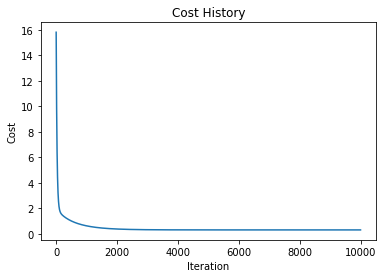

Train error rate: 0.5504200664658345
Test error rate: 0.6053660924842965


In [5]:
# Vanilia Gradient Descent Algorithms
def gradient_descent(X, y, learning_rate, num_iterations):
    num_samples, num_features = X.shape
    
    # Initialize weights and bias
    w = np.zeros(num_features)
    b = 0
    cost_history = []
    
    for _ in range(num_iterations):
        # Calculate predictions
        y_pred = np.dot(X, w) + b
        
        # Calculate the difference between predictions and actual values
        error = y_pred - y
        
        # Calculate the gradient
        w_gradient = (1/num_samples) * np.dot(X.T, error)
        b_gradient = (1/num_samples) * np.sum(error)
        
        # Update theta using the learning rate and gradient
        w -= learning_rate * w_gradient
        b -= learning_rate * b_gradient
        
        # Calculate the cost (mean squared error)
        cost = np.mean(np.square(error))
        cost_history.append(cost)
    
    return w, b, cost_history

# Train the model using gradient descent
learning_rate = 0.01
num_iterations = 10000
w, b, cost_history = gradient_descent(X_train_normalized, y_train, learning_rate, num_iterations)

# Print the learned parameters
print("Learned parameters:")

for i, w_i in enumerate(w):
    print(f"w{i} =", w_i)
print("b =", b)

# Plot the cost history
plt.plot(cost_history)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Cost History")
plt.show()

# Calculate train error rate
train_error_rate = calculate_error_rate(X_train_normalized,  y_train, w, b)
print("Train error rate:", train_error_rate)
    
# Calculate test error rate if test data is provided
if X_test is not None and y_test is not None:
    test_error_rate = calculate_error_rate(X_test_normalized, y_test, w, b)
    print("Test error rate:", test_error_rate)

Learned parameters:
w0 = 0.060430800816724736
w1 = -2.1368244029430628
w2 = 3.8469290826364695
b = 2.8683084597402173


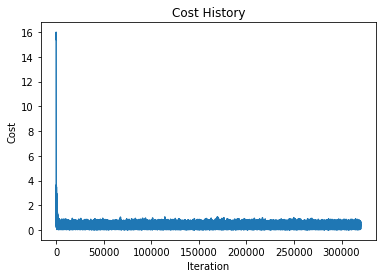

Train error rate: 0.5504211634399071
Test error rate: 0.6056949344854938


In [6]:
# Stochastic Gradien Descent Algorithms
def stochastic_gradient_descent(X, y, learning_rate, num_epochs, batch_size):
    num_samples, num_features = X.shape
    num_batches = num_samples // batch_size

    # Initialize weights and bias
    w = np.zeros(num_features)
    b = 0
    cost_history = []

    for epoch in range(num_epochs):
        # Shuffle the data for each epoch
        permutation = np.random.permutation(num_samples)
        X_shuffled = X[permutation]
        y_shuffled = y[permutation]

        for batch in range(num_batches):
            # Select the current batch
            start = batch * batch_size
            end = (batch + 1) * batch_size
            X_batch = X_shuffled[start:end]
            y_batch = y_shuffled[start:end]

            # Calculate predictions
            y_pred = np.dot(X_batch, w) + b

            # Calculate the difference between predictions and actual values
            error = y_pred - y_batch

            # Calculate the gradients
            w_gradient = (1 / batch_size) * np.dot(X_batch.T, error)
            b_gradient = (1 / batch_size) * np.sum(error)

            # Update weights and bias
            w -= learning_rate * w_gradient
            b -= learning_rate * b_gradient

            # Calculate the cost (mean squared error)
            cost = np.mean(np.square(error))
            cost_history.append(cost)
            
    return w, b, cost_history

# Train the model using stochastic gradient descent
learning_rate = 0.01
num_epochs = 10000
batch_size = 10
w, b, cost_history = stochastic_gradient_descent(X_train_normalized, y_train, learning_rate, num_epochs, batch_size)

# Print the learned parameters
print("Learned parameters:")
for i, w_i in enumerate(w):
    print(f"w{i} =", w_i)
print("b =", b)

# Plot the cost history
plt.plot(cost_history)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Cost History")
plt.show()

# Calculate train error rate
train_error_rate = calculate_error_rate(X_train_normalized,  y_train, w, b)
print("Train error rate:", train_error_rate)
    
# Calculate test error rate if test data is provided
if X_test is not None and y_test is not None:
    test_error_rate = calculate_error_rate(X_test_normalized, y_test, w, b)
    print("Test error rate:", test_error_rate)

Pytorch SGD

Pytorch SGD Test (This is done by Chris for testing purpose)

Trained weights: tensor([ 0.0608, -2.1335,  3.8474], requires_grad=True)
Trained bias: tensor([2.8643], requires_grad=True)


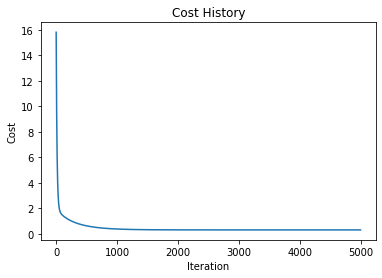

Train error rate: 0.5504200649769682
Test error rate: 0.6053662950911989


In [7]:
# Define the learning rate and number of epochs
learning_rate = 0.01
num_epochs = 5000

# Define the number of features
num_features = X_train_tensor.size()[1]

# Define the model parameters (weights and bias)
w = torch.zeros(num_features, dtype=torch.float, requires_grad=True)
b = torch.zeros(1, dtype=torch.float, requires_grad=True)
cost_history = []

# Define the loss function
criterion = torch.nn.MSELoss()

# Define the optimizer (Vanilla Gradient Descent)
optimizer = torch.optim.SGD([w, b], lr=learning_rate)

# Perform gradient descent
for epoch in range(num_epochs):
    # Forward pass
    outputs = torch.matmul(X_train_tensor.float(), w) + b
    loss = criterion(outputs, y_train_tensor.float())

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Record the loss
    cost_history.append(loss.detach().numpy())
    
#    # Print the loss every 10 epochs
#    if (epoch + 1) % 10 == 0:
#        print(f'Epoch [{epoch+1}], Loss: {loss.item():.8f}')
        

# Print learned parameters
print('Trained weights:', w)
print('Trained bias:', b)

# Plot the cost history
plt.plot(cost_history)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Cost History")
plt.show()

# Calculate train error rate
train_error_rate = calculate_error_rate(X_train_normalized,  y_train, w.detach().numpy(), b.detach().numpy())
print("Train error rate:", train_error_rate)
    
# Calculate test error rate if test data is provided
if X_test is not None and y_test is not None:
    test_error_rate = calculate_error_rate(X_test_normalized, y_test, w.detach().numpy(), b.detach().numpy())
    print("Test error rate:", test_error_rate)

Neural Network

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (activation_stack): Sequential(
    (0): Linear(in_features=3, out_features=320, bias=True)
    (1): ReLU()
  )
)
Epoch [10/5000], Loss: 14.43301296
Epoch [20/5000], Loss: 14.42140007
Epoch [30/5000], Loss: 14.40973377
Epoch [40/5000], Loss: 14.39802361
Epoch [50/5000], Loss: 14.38626003
Epoch [60/5000], Loss: 14.37445068
Epoch [70/5000], Loss: 14.36259747
Epoch [80/5000], Loss: 14.35070038
Epoch [90/5000], Loss: 14.33875942
Epoch [100/5000], Loss: 14.32678223
Epoch [110/5000], Loss: 14.31475830
Epoch [120/5000], Loss: 14.30269051
Epoch [130/5000], Loss: 14.29057407
Epoch [140/5000], Loss: 14.27841282
Epoch [150/5000], Loss: 14.26620579
Epoch [160/5000], Loss: 14.25396252
Epoch [170/5000], Loss: 14.24168110


C:\Users\chris\.julia\conda\3\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([320])) that is different to the input size (torch.Size([320, 320])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [180/5000], Loss: 14.22936535
Epoch [190/5000], Loss: 14.21701622
Epoch [200/5000], Loss: 14.20462990
Epoch [210/5000], Loss: 14.19220257
Epoch [220/5000], Loss: 14.17973042
Epoch [230/5000], Loss: 14.16722393
Epoch [240/5000], Loss: 14.15468979
Epoch [250/5000], Loss: 14.14212894
Epoch [260/5000], Loss: 14.12953854
Epoch [270/5000], Loss: 14.11691856
Epoch [280/5000], Loss: 14.10426426
Epoch [290/5000], Loss: 14.09157467
Epoch [300/5000], Loss: 14.07885265
Epoch [310/5000], Loss: 14.06610489
Epoch [320/5000], Loss: 14.05332661
Epoch [330/5000], Loss: 14.04052258
Epoch [340/5000], Loss: 14.02768517
Epoch [350/5000], Loss: 14.01482296
Epoch [360/5000], Loss: 14.00193119
Epoch [370/5000], Loss: 13.98901081
Epoch [380/5000], Loss: 13.97606087
Epoch [390/5000], Loss: 13.96308804
Epoch [400/5000], Loss: 13.95008755
Epoch [410/5000], Loss: 13.93706512
Epoch [420/5000], Loss: 13.92401409
Epoch [430/5000], Loss: 13.91094494
Epoch [440/5000], Loss: 13.89785194
Epoch [450/5000], Loss: 13.8

Epoch [2430/5000], Loss: 11.11068821
Epoch [2440/5000], Loss: 11.09749222
Epoch [2450/5000], Loss: 11.08431625
Epoch [2460/5000], Loss: 11.07115746
Epoch [2470/5000], Loss: 11.05801868
Epoch [2480/5000], Loss: 11.04489994
Epoch [2490/5000], Loss: 11.03179932
Epoch [2500/5000], Loss: 11.01871967
Epoch [2510/5000], Loss: 11.00566196
Epoch [2520/5000], Loss: 10.99262619
Epoch [2530/5000], Loss: 10.97961044
Epoch [2540/5000], Loss: 10.96661091
Epoch [2550/5000], Loss: 10.95363522
Epoch [2560/5000], Loss: 10.94068241
Epoch [2570/5000], Loss: 10.92775249
Epoch [2580/5000], Loss: 10.91484356
Epoch [2590/5000], Loss: 10.90195560
Epoch [2600/5000], Loss: 10.88909149
Epoch [2610/5000], Loss: 10.87624741
Epoch [2620/5000], Loss: 10.86342812
Epoch [2630/5000], Loss: 10.85063267
Epoch [2640/5000], Loss: 10.83785915
Epoch [2650/5000], Loss: 10.82510853
Epoch [2660/5000], Loss: 10.81237793
Epoch [2670/5000], Loss: 10.79966831
Epoch [2680/5000], Loss: 10.78697777
Epoch [2690/5000], Loss: 10.77430916
E

Epoch [4690/5000], Loss: 8.61137009
Epoch [4700/5000], Loss: 8.60225201
Epoch [4710/5000], Loss: 8.59314919
Epoch [4720/5000], Loss: 8.58406353
Epoch [4730/5000], Loss: 8.57499123
Epoch [4740/5000], Loss: 8.56593704
Epoch [4750/5000], Loss: 8.55689812
Epoch [4760/5000], Loss: 8.54787540
Epoch [4770/5000], Loss: 8.53886700
Epoch [4780/5000], Loss: 8.52987576
Epoch [4790/5000], Loss: 8.52090073
Epoch [4800/5000], Loss: 8.51194000
Epoch [4810/5000], Loss: 8.50299644
Epoch [4820/5000], Loss: 8.49406719
Epoch [4830/5000], Loss: 8.48515415
Epoch [4840/5000], Loss: 8.47625637
Epoch [4850/5000], Loss: 8.46737671
Epoch [4860/5000], Loss: 8.45851040
Epoch [4870/5000], Loss: 8.44966030
Epoch [4880/5000], Loss: 8.44082642
Epoch [4890/5000], Loss: 8.43200970
Epoch [4900/5000], Loss: 8.42320919
Epoch [4910/5000], Loss: 8.41442394
Epoch [4920/5000], Loss: 8.40565586
Epoch [4930/5000], Loss: 8.39690399
Epoch [4940/5000], Loss: 8.38816547
Epoch [4950/5000], Loss: 8.37944221
Epoch [4960/5000], Loss: 8.3

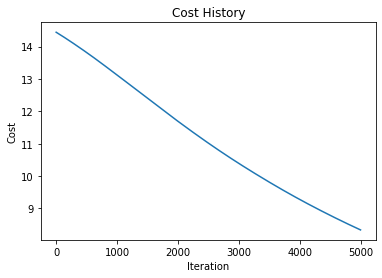

In [8]:
# Define a custom neural network class
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.activation_stack = nn.Sequential(
            nn.Linear(3, 320),
            nn.ReLU(),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.activation_stack(x)
        return logits
    
# Define the learning rate and number of epochs
learning_rate = 0.01
num_epochs = 5000

# Define the number of features
num_features = X_train_tensor.size()[1]

# Define the model parameters
cost_history = []

# Create an instance of the neural network
criterion = nn.MSELoss()
NeuralNetwork_model = NeuralNetwork()
print(NeuralNetwork_model)
optimizer = torch.optim.SGD(NeuralNetwork_model.parameters(), lr=learning_rate)

# Perform training
for epoch in range(num_epochs):
    # Forward propagation to obtain the predicted output
    outputs = NeuralNetwork_model(X_train_tensor.float())
    
    # Calculate the loss
    loss = criterion(outputs, y_train_tensor.float())
    
    # Backward propagation and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Record the loss
    cost_history.append(loss.item())
    
    # Print the loss every 100 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.8f}')
        
# Print learned parameters
for name, param in NeuralNetwork_model.named_parameters():
    if param.requires_grad:
        print(f'{name}: {param.data}')
        
# Plot the cost history
plt.plot(cost_history)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Cost History")
plt.show()